In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [19]:
mag_bin = 14
tic =  357686299#422305731#
data = pd.read_csv(f'./heatmap_data_mag_{mag_bin}/{tic}_heatmap.csv')

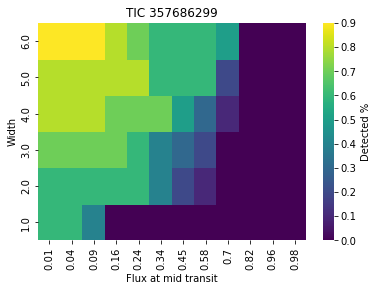

In [20]:
data = pd.read_csv(f'./heatmap_data_mag_{mag_bin}/{tic}_heatmap.csv')
data_pivoted = data.pivot("Width", "Flux at mid transit", "Detected")

data_pivoted = sns.heatmap(data_pivoted, cmap="viridis")



plt.title(f"TIC {tic}")
data_pivoted.collections[0].colorbar.set_label("Detected %")
data_pivoted.invert_yaxis()
plt.show()
